# Example: Quality Control Module
The following example runs a simple quality control analysis on wave elevation data. 
The source code for MHKiT's qc module is in the [\\MHKiT\qc](https://code.primre.org/mhkit/mhkit-python/tree/master/mhkit/wave) directory.
The data file used in this example is stored in the [\\MHKiT\examples\data](https://code.primre.org/mhkit/mhkit-python/tree/master/examples/data) directory. 

Start by importing the necessary modules:

In [19]:
import pandas as pd
import mhkit

Then load the data into a pandas DataFrame.  The data includes several issues, including timestamps that are out of order, corrupt data with values of -999, data outside expected range, and stagant data.  The first 5 rows of data are shown below, along with a plot.

        probe1  probe2  probe3
Time                          
10.000   24.48   28.27     1.3
10.002   34.48   40.27    -8.7
10.004   30.48   38.27   -13.7
10.006   12.48   24.27   -32.7
10.008   13.48   22.27   -21.7


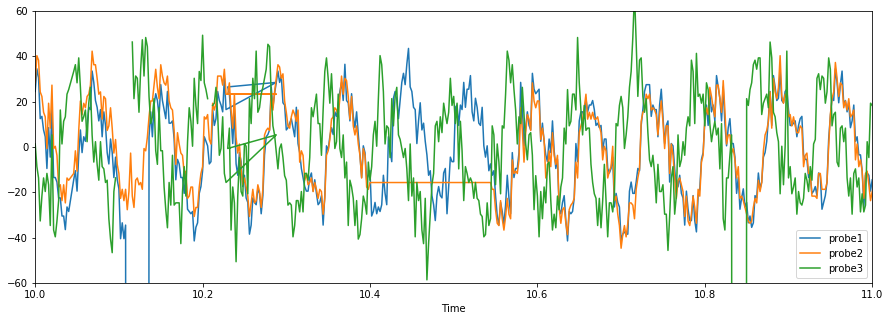

In [20]:
data = pd.read_csv('data/wave_elevation_data.csv', index_col='Time')
data.plot(figsize=(15,5), ylim=(-60,60))
print(data.head())

The data is indexed by time in seconds. To use the quality control functions, the data must be indexed by datetime.  The index can be converted to datetime using the following utility function.

In [21]:
data.index = mhkit.utils.index_to_datetime(data.index, origin='2019-05-20')
print(data.head())

                         probe1  probe2  probe3
Time                                           
2019-05-20 00:00:10.000   24.48   28.27     1.3
2019-05-20 00:00:10.002   34.48   40.27    -8.7
2019-05-20 00:00:10.004   30.48   38.27   -13.7
2019-05-20 00:00:10.006   12.48   24.27   -32.7
2019-05-20 00:00:10.008   13.48   22.27   -21.7


## Quality control tests
The following quality control tests are used to identify timestamp issues along with corrupt data, data outside expected range, and stagnant data.

Each quality control tests results in the following information:

* Cleaned data, which is a DataFrame that has *NaN* in place of data that did not pass the quality control test
* Boolean mask, which is a DataFrame with True/False that indicates if each data point passed the quality control test
* Summary of the quality control test results, the summary includes the variable name (which is blank for timestamp issues), the start and end time of the test failure, and an error flag for each test failure

## Check timestamp
Quality control analysis generally starts by checking to see if the data contains duplicate timestamps, timestamps that are not monotonically increasing, and timestamps that occur at irregular intervals (an interval of 0.002s is expected for this data). 

If duplicate timestamps are found, the resulting DataFrames (cleaned data and mask) keep the first occurrence. If timestamps are not monotonic, the timestamps in the resulting DataFrames are reordered.

In [22]:
results = mhkit.qc.check_timestamp(data, 0.002)

The cleaned data, boolean mask, and test results summary are shown below. The summary is transposed (.T) so that it is easier to read.

                         probe1  probe2  probe3
2019-05-20 00:00:10.000   24.48   28.27     1.3
2019-05-20 00:00:10.002   34.48   40.27    -8.7
2019-05-20 00:00:10.004   30.48   38.27   -13.7
2019-05-20 00:00:10.006   12.48   24.27   -32.7
2019-05-20 00:00:10.008   13.48   22.27   -21.7


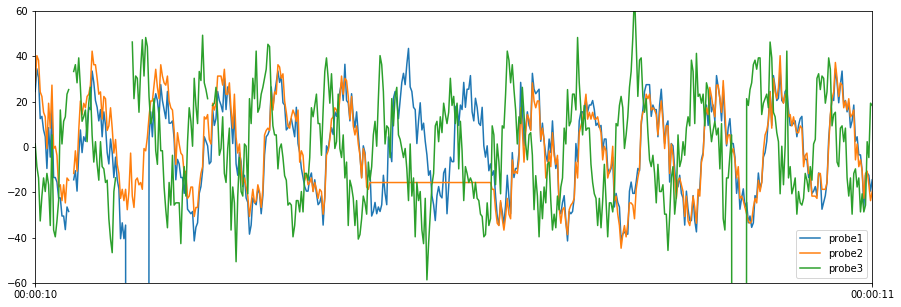

In [23]:
results['cleaned_data'].plot(figsize=(15,5), ylim=(-60,60))
print(results['cleaned_data'].head())

In [24]:
print(results['mask'].head())

                         probe1  probe2  probe3
2019-05-20 00:00:10.000    True    True    True
2019-05-20 00:00:10.002    True    True    True
2019-05-20 00:00:10.004    True    True    True
2019-05-20 00:00:10.006    True    True    True
2019-05-20 00:00:10.008    True    True    True


In [25]:
print(results['test_results'].T)

                                        0                           1  \
Variable Name                                                           
Start Time     2019-05-20 00:00:10.230000  2019-05-20 00:00:10.340000   
End Time       2019-05-20 00:00:10.230000  2019-05-20 00:00:10.340000   
Timesteps                               1                           1   
Error Flag         Nonmonotonic timestamp         Duplicate timestamp   

                                        2  
Variable Name                              
Start Time     2019-05-20 00:00:10.042000  
End Time       2019-05-20 00:00:10.044000  
Timesteps                               2  
Error Flag              Missing timestamp  


## Check for corrupt data
In the following qualtiy control tests, the cleaned data from the previous test is used as input to the subsequent test. For each quality control test, a plot of the cleaned data is shown along with the test results summary.

Note, that if you want to run a series of quality control tests before extracting the cumulative cleaned data, boolean mask, and summary, we recomment using Pecos directly with the object-orieinted approach, see https://pecos.readthedocs.io/ for more details.

The quality control test below check for corrupt data, indicated by a value of -999.

                                        0                           1
Variable Name                      probe1                      probe3
Start Time     2019-05-20 00:00:10.110000  2019-05-20 00:00:10.834000
End Time       2019-05-20 00:00:10.134000  2019-05-20 00:00:10.848000
Timesteps                              13                           8
Error Flag                   Corrupt data                Corrupt data


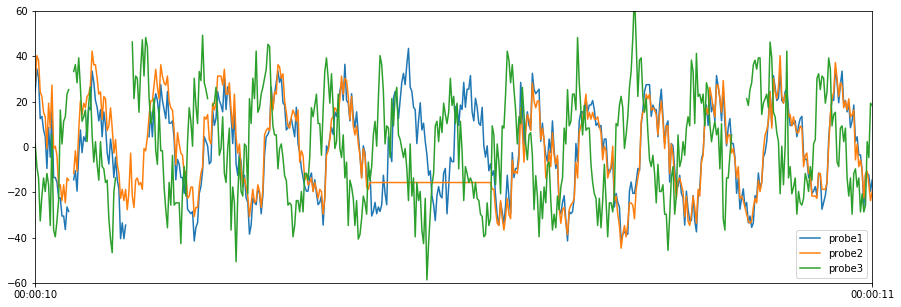

In [26]:
results = mhkit.qc.check_corrupt(results['cleaned_data'], [-999])

results['cleaned_data'].plot(figsize=(15,5), ylim=(-60,60))
print(results['test_results'].T)

## Check for data outside expected range
The next quality control test checks for data that is greater than 50 or less than -50. 

Empty DataFrame
Columns: []
Index: [Variable Name, Start Time, End Time, Timesteps, Error Flag]


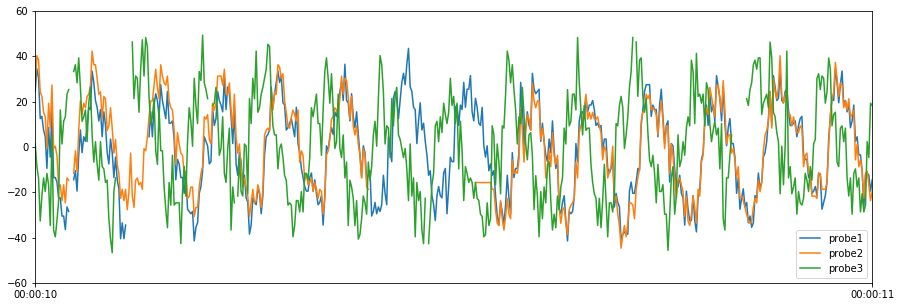

In [29]:
results = mhkit.qc.check_range(results['cleaned_data'], [-50, 50])

results['cleaned_data'].plot(figsize=(15,5), ylim=(-60,60))
print(results['test_results'].T)

## Check for stagnant data
The final quality control test checks for stagnant data by looking for data that changes by less than 0.001 within a 0.02 second moving window. 

Empty DataFrame
Columns: []
Index: [Variable Name, Start Time, End Time, Timesteps, Error Flag]


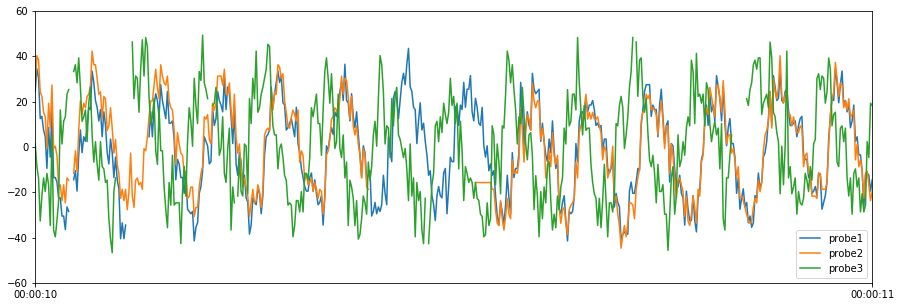

In [30]:
results = mhkit.qc.check_delta(results['cleaned_data'], [0.001, None], window=0.02)

results['cleaned_data'].plot(figsize=(15,5), ylim=(-60,60))
print(results['test_results'].T)

The cleaned data can be used directly in MHKiT analysis, or the missing values can be replaced using various methods before analysis is run. 
Data replacement strategies are generally defined on a case by case basis. Pandas includes methods to interpolate, replace, and fill missing values.

In [31]:
cleaned_data = results['cleaned_data']

# Kelley's notes: 
- revised to make examples have similar structure and reference source code
- it would be nice to comment each line of code so that it is clear what the input parameters are doing. 

For example: 

`results = mhkit.qc.check_range(results['cleaned_data'], [-50, 50]) #applies check_range method to 'cleaned data' column of results, looks for data outside of [-50,50] range`

Or:

`results = mhkit.qc.check_range(results['cleaned_data'], [-50, 50]) #dataframe = mhkit.qc.check_range(dataframe['column'], [min, max])`